# 03_ContextClassifier

## 03.1 Synonym Dictionary

Import relevant packages

In [1]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load the Downstream CSV file into a DataFrame with the correct encoding
downstream = pd.read_csv('Downstream.csv', encoding='latin1')

# Load the InputGoods CSV file into a DataFrame with the correct encoding
input_goods = pd.read_csv('InputGoods.csv', encoding='latin1')

gov_docs = pd.read_csv('preprocessed_gov_docs.csv')

In [3]:
# Drop specified columns from gov_docs
columns_to_drop = ["extracted_text", "tokenized_text", "no_stopwords_text", "lemmatized_text", "mentions_child_labour", "mentions_forced_child_labour", "lemmatized_text_str", "mentions_forced_labour"]
gov_docs = gov_docs.drop(columns=columns_to_drop)

In [4]:
# Extract unique goods from the correct columns
downstream_goods = downstream['TVPRA Downstream Good'].dropna().unique().tolist()
input_goods_list = input_goods['Good'].dropna().unique().tolist()

# Combine and deduplicate the goods list
all_goods = sorted(set(downstream_goods + input_goods_list))

# Create initial synonym dictionary with goods mapping to themselves
goods_synonyms = {good: [good] for good in all_goods}

# Display the synonym dictionary
goods_synonyms

{'Alcoholic Beverages': ['Alcoholic Beverages'],
 'Aluminum': ['Aluminum'],
 'Amber': ['Amber'],
 'Animal Feed': ['Animal Feed'],
 'Artificial Flowers': ['Artificial Flowers'],
 'Auto Parts and Components (Aluminum) ': ['Auto Parts and Components (Aluminum) '],
 'Açaí Berries': ['Açaí Berries'],
 'Bagasse ': ['Bagasse '],
 'Baked Goods': ['Baked Goods'],
 'Bamboo': ['Bamboo'],
 'Bananas': ['Bananas'],
 'Beans ': ['Beans '],
 'Beans (green beans)': ['Beans (green beans)'],
 'Beans (green, soy, yellow)': ['Beans (green, soy, yellow)'],
 'Beef': ['Beef'],
 'Bidis (hand-rolled cigarettes)': ['Bidis (hand-rolled cigarettes)'],
 'Biofuel': ['Biofuel'],
 'Bovines': ['Bovines'],
 'Brassware': ['Brassware'],
 'Brazil Nuts/Chestnuts': ['Brazil Nuts/Chestnuts'],
 'Bricks': ['Bricks'],
 'Bricks (clay)': ['Bricks (clay)'],
 'Broccoli': ['Broccoli'],
 'Cabbages': ['Cabbages'],
 'Carpets': ['Carpets'],
 'Carrots': ['Carrots'],
 'Cashews': ['Cashews'],
 'Cattle': ['Cattle'],
 'Caustic Soda': ['Caustic

Will now remove US versions of goods keys in this dictionary, to be repaced by Uk ones later, and also goods in the incorrect format (e.g. 'Cigarettes (Tobacco)'', to be replaced with the correct format (e.g. 'Cigarettes'))

In [5]:
# List of goods to remove from the synonym dictionary
goods_to_remove = [
    'Aluminum', 'Cigarettes (Tobacco)', 'Cigarettes (Tobacco) ', 'Cobalt Ore (heterogenite)', 'Chile Peppers'
    'Coca (stimulant plant)', 'Cocoa Paste ', 'Crude Palm Oil ', 'Eggplants',
    'Leather Goods/Accessories', 'Lithium-Ion Batteries ', 'Manioc/Cassava', 'Oleochemicals ',
    'Refined Palm Kernel Oil ', 'Refined Palm Oil ', 'Shrimp', 'Soccer Balls', 'Tilapia (fish)',
    'Tungsten Ore (wolframite)', 'Yerba Mate (stimulant plant)'
]

# Remove the specified goods from the synonym dictionary
for good in goods_to_remove:
    if good in goods_synonyms:
        del goods_synonyms[good]

# Display the updated synonym dictionary
goods_synonyms

{'Alcoholic Beverages': ['Alcoholic Beverages'],
 'Amber': ['Amber'],
 'Animal Feed': ['Animal Feed'],
 'Artificial Flowers': ['Artificial Flowers'],
 'Auto Parts and Components (Aluminum) ': ['Auto Parts and Components (Aluminum) '],
 'Açaí Berries': ['Açaí Berries'],
 'Bagasse ': ['Bagasse '],
 'Baked Goods': ['Baked Goods'],
 'Bamboo': ['Bamboo'],
 'Bananas': ['Bananas'],
 'Beans ': ['Beans '],
 'Beans (green beans)': ['Beans (green beans)'],
 'Beans (green, soy, yellow)': ['Beans (green, soy, yellow)'],
 'Beef': ['Beef'],
 'Bidis (hand-rolled cigarettes)': ['Bidis (hand-rolled cigarettes)'],
 'Biofuel': ['Biofuel'],
 'Bovines': ['Bovines'],
 'Brassware': ['Brassware'],
 'Brazil Nuts/Chestnuts': ['Brazil Nuts/Chestnuts'],
 'Bricks': ['Bricks'],
 'Bricks (clay)': ['Bricks (clay)'],
 'Broccoli': ['Broccoli'],
 'Cabbages': ['Cabbages'],
 'Carpets': ['Carpets'],
 'Carrots': ['Carrots'],
 'Cashews': ['Cashews'],
 'Cattle': ['Cattle'],
 'Caustic Soda': ['Caustic Soda'],
 'Cement': ['Cemen

In [6]:
# Manually defined synonym expansions for UK/US and domain-specific terms
custom_synonyms = {
    "Açaí Berries": ["Açaí Berries", "Acai", 'Acai Berries'],
    "Aluminium": ["Aluminium", "Aluminum"],
    "Aubergine": ["Aubergine", "Aubergines", "Brinjals", "Eggplant", "Eggplants"],
    "Beetroot": ["Beetroot", "Beet"],
    "Carpets": ["Carpets", "Rugs"],
    "Cassava": ["Cassava", 'Manioc', 'Yuca', 'Manioc/Cassava'],
    "Chickpeas": ["Chickpeas", "Garbanzo Beans"],
    "Chili Peppers": ["Chili Peppers", "Chile Peppers", "Chilli Peppers"],
    "Cobalt Ore": ["Cobalt Ore", "Cobalt"],
    "Coca": ["Coca", 'Coca (Stimulant)'],
    "Cocoa": ["Cocoa", "Cacao"],
    "Cotton": ["Cotton", "Cottonseed", "Cottonseed (hybrid)", "Textiles (Cotton)", "Garments (Cotton)", "Thread/Yarn (Cotton)"],
    "Courgettes": ['Courgettes', 'Courgette', 'Zucchini', 'Zucchinis'],
    "Coriander": ["Coriander", "Cilantro"],
    "Footballs": ["Footballs", "Soccer Balls"],
    "Footwear": ["Footwear", "Shoes", "Sandals", "Boots"],
    "Garments": ["Garments", "Clothing", "Apparel"],
    "Groundnuts": ["Groundnuts", "Peanuts"],
    "Jewellery": ["Jewellery", "Jewelry"],
    "Leather": ["Leather", "Leather Goods", "Leather Accessories"],
    "Lithium-Ion Batteries": ["Lithium-Ion Batteries", "Lithium Batteries"],
    "Maize": ["Maize", "Corn"],
    "Petrol": ["Petrol", "Gasoline"],
    "Prawns": ["Prawns", "Shrimp"],
    "Rubber": ["Rubber", "Latex"],
    "Silk Fabric": ["Silk Fabric", "Silk"],
    "Soybeans": ["Soybeans", "Soya", "Soy"],
    "Sugarcane": ["Sugarcane", "Sugar Cane"],
    "Sweet Potatoes": ["Sweet Potatoes", "Yams", "Sweet Potato"],
    "Tea": ["Tea", "Chai"],
    "Tilapia": ["Tilapia", "Tilapia (fish)"],
    "Timber": ["Timber", "Lumber"],
    "Tomatoes": ["Tomatoes", "Tomato"],
    "Tungsten": ["Tungsten", "Tungsten Ore", "Tungsten Ore (wolframite)"],
    "Yerba Mate": ["Yerba Mate", "Mate", "Yerba", "Yerba Mate (stimulant plant)"]
}

# Enrich the synonym dictionary
for standard_term, synonyms in custom_synonyms.items():
    # If the standard term already exists, extend its synonym list
    if standard_term in goods_synonyms:
        current_synonyms = set(goods_synonyms[standard_term])
        goods_synonyms[standard_term] = sorted(current_synonyms.union(synonyms))
    else:
        # Try to map to an existing term in the original list
        for good in goods_synonyms.keys():
            if standard_term.lower() in good.lower() or good.lower() in standard_term.lower():
                current_synonyms = set(goods_synonyms[good])
                goods_synonyms[good] = sorted(current_synonyms.union(synonyms))
                break
        else:
            # If no close match found, just add the new term as a new entry
            goods_synonyms[standard_term] = sorted(set(synonyms))

# Display enriched synonym dictionary (partial sample for preview)
dict(list(goods_synonyms.items())[:])

{'Alcoholic Beverages': ['Alcoholic Beverages'],
 'Amber': ['Amber'],
 'Animal Feed': ['Animal Feed'],
 'Artificial Flowers': ['Artificial Flowers'],
 'Auto Parts and Components (Aluminum) ': ['Auto Parts and Components (Aluminum) '],
 'Açaí Berries': ['Acai', 'Acai Berries', 'Açaí Berries'],
 'Bagasse ': ['Bagasse '],
 'Baked Goods': ['Baked Goods'],
 'Bamboo': ['Bamboo'],
 'Bananas': ['Bananas'],
 'Beans ': ['Beans '],
 'Beans (green beans)': ['Beans (green beans)'],
 'Beans (green, soy, yellow)': ['Beans (green, soy, yellow)'],
 'Beef': ['Beef'],
 'Bidis (hand-rolled cigarettes)': ['Bidis (hand-rolled cigarettes)'],
 'Biofuel': ['Biofuel'],
 'Bovines': ['Bovines'],
 'Brassware': ['Brassware'],
 'Brazil Nuts/Chestnuts': ['Brazil Nuts/Chestnuts'],
 'Bricks': ['Bricks'],
 'Bricks (clay)': ['Bricks (clay)'],
 'Broccoli': ['Broccoli'],
 'Cabbages': ['Cabbages'],
 'Carpets': ['Carpets', 'Rugs'],
 'Carrots': ['Carrots'],
 'Cashews': ['Cashews'],
 'Cattle': ['Cattle'],
 'Caustic Soda': ['Ca

## 03.2 Flatten Synonym Dictionary

If a synonym is detected in the coporate governance documents I want to convert them to the canonical (UK-English) form e.g. I want all aubergine and eggplant mentions to be retruned as 'Aubergine'

In [7]:
# Flatten the synonym dictionary: maps all variations to the canonical UK term
reverse_synonyms = {}

for standard_good, synonyms in goods_synonyms.items():
    for synonym in synonyms:
        reverse_synonyms[synonym.lower()] = standard_good

# Check sample output
print("eggplant →", reverse_synonyms.get("eggplant"))
print("aubergine →", reverse_synonyms.get("aubergine"))
print("maize →", reverse_synonyms.get("maize"))
print("corn ->", reverse_synonyms.get("corn"))

eggplant → Aubergine
aubergine → Aubergine
maize → Maize
corn -> Maize


## 03.3 PhraseMatcher

The goal with this project is to automatically scan through cleaned governance report text (extracted_text_clean) and detect mentions of goods — including all their known synonyms or variations.

The problem is dictionary-based entity recognition — not generic language understanding.
We already have a curated list of goods + synonyms (domain-specific knowledge).
PhraseMatcher is:
- Fast
- Accurate
- Lightweight (no machine learning model needed)
- Perfect for exact or near-exact phrase matching.

In [8]:
# Load small English language model
nlp = spacy.load("en_core_web_sm")

# Initialize PhraseMatcher with lowercase matching
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

# Add patterns (all synonyms) to the matcher
patterns = [nlp.make_doc(synonym) for synonym in reverse_synonyms.keys()]
matcher.add("GOOD", patterns)

print(f"Total patterns added for matching: {len(patterns)}")


Total patterns added for matching: 265


This previous steps adds patterns from our goods_synoynm dictionary to the Phrase matcher which will then scan through the governance docs and detect mentions of all synonyms 

Now will create a function to detect goods from the governance doc text data, the reverse_synonyms is then applied to return the mentions of good in their flattened, canonical form

In [9]:
# Function to detect goods from a given text
def detect_goods(text):
    doc = nlp(text)
    matches = matcher(doc)
    detected = set()
    
    for match_id, start, end in matches:
        matched_phrase = doc[start:end].text.lower()  # matched word from text
        standard_good = reverse_synonyms.get(matched_phrase, matched_phrase)  # map to standard good
        detected.add(standard_good)
        
    return list(detected)

The Spacy prhase matcher will only search through 1,000,000 charcaters in each cell. One of the gov docs is >1,000,000 characters so will manualy increase this + then apply the function

In [10]:
# Load your spaCy model
nlp = spacy.load("en_core_web_sm")

# Increase the maximum length limit
nlp.max_length = 3000000

# Apply the function to your clean text column (preprocessed)
gov_docs['detected_goods'] = gov_docs['extracted_text_clean'].apply(detect_goods)

In [11]:
gov_docs[['extracted_text_clean', 'detected_goods']].head(10)

,extracted_text_clean,detected_goods
0,supply chain code of conduct | urban logistics...,[]
1,position statement on human rights abbott beli...,[]
2,3 2019 accelerating progress toward a sustaina...,"[Coffee, Solar Cells, Cobalt Ore, Tin, Tungste..."
3,gri sustainability reporting standards skip to...,[]
4,building foundations for a sustainable future ...,[Cement]
5,renewi plc modern slavery statement 2023 intro...,[]
6,1 code of conduct code of conduct you are the ...,"[Lead, Garments]"
7,modern slavery statement amazon (newline) (ne...,"[Cobalt Ore, Tin, Electronics, Tungsten, Cotto..."
8,ethics and compliance skip to main content abo...,[Petrol]
9,supplier code of conduct revised may 2024 1. i...,"[Gold, Tin, Tungsten]"


this took a while to run so will save as new csv, can import this table later as gov_docs instead of running the phrasematcher model again

In [12]:
# Output the updated gov_docs dataframe to a CSV file
gov_docs.to_csv("detected_goods_gov_docs.csv", index=False)

## 03.3.1 Some visualisations of detected goods

In [13]:
# Flatten the list of detected goods across all documents
all_detected_goods = sum(gov_docs['detected_goods'], [])

# Count frequencies
goods_counts = Counter(all_detected_goods)

# Convert to DataFrame for plotting
goods_freq_df = pd.DataFrame(goods_counts.items(), columns=["Good", "Frequency"])
goods_freq_df = goods_freq_df.sort_values(by="Frequency", ascending=False)


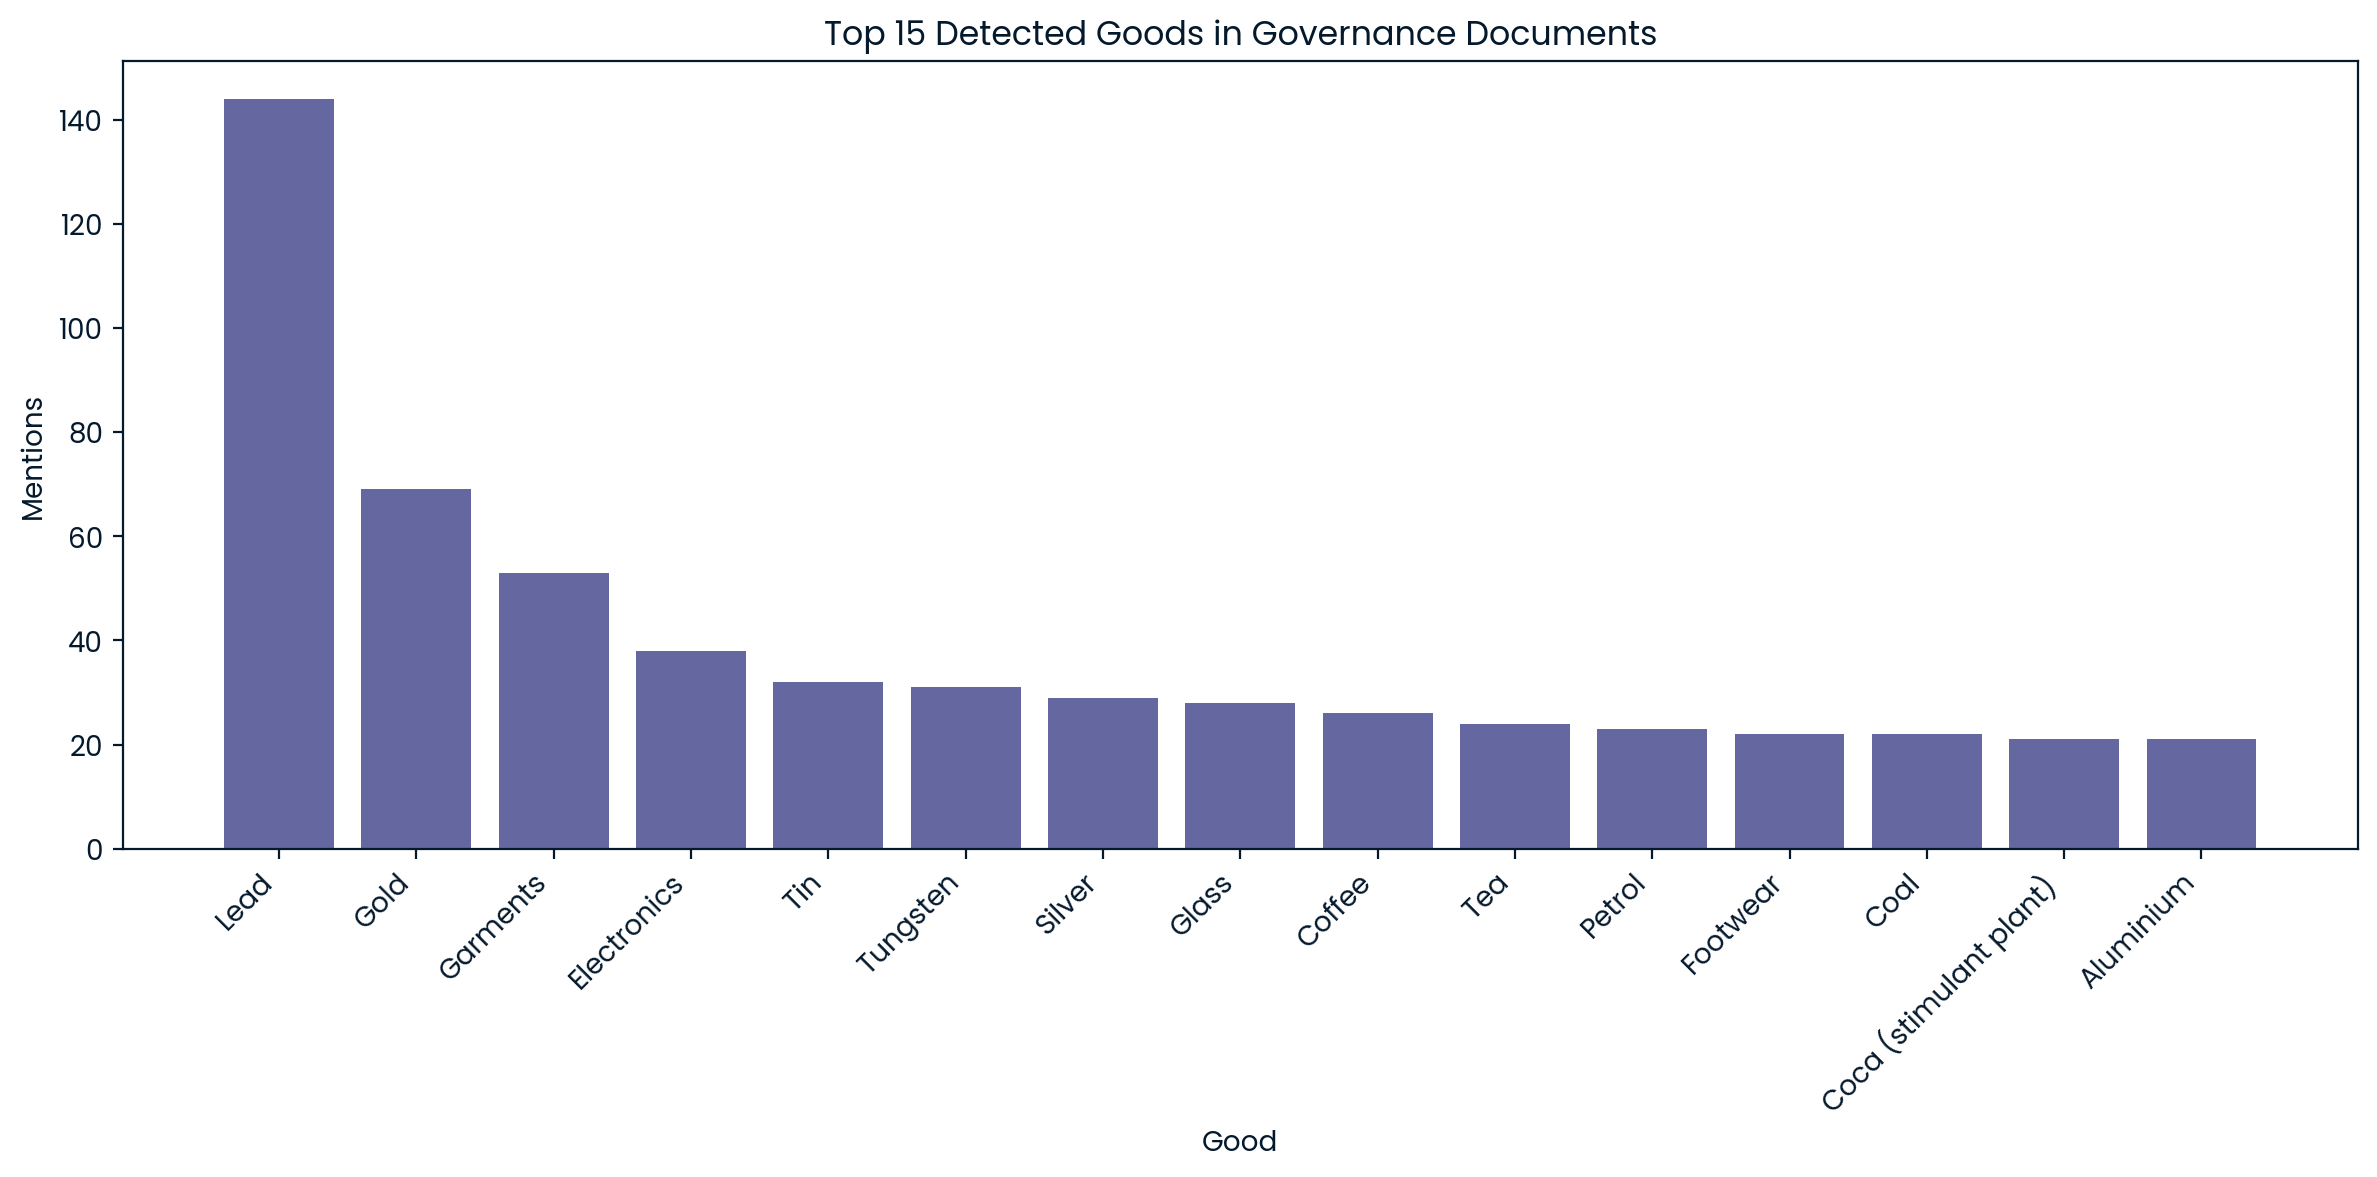

In [14]:
# Select top N goods
top_n = 15
top_goods = goods_freq_df.head(top_n)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_goods["Good"], top_goods["Frequency"])
plt.title(f"Top {top_n} Detected Goods in Governance Documents")
plt.xlabel("Good")
plt.ylabel("Mentions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

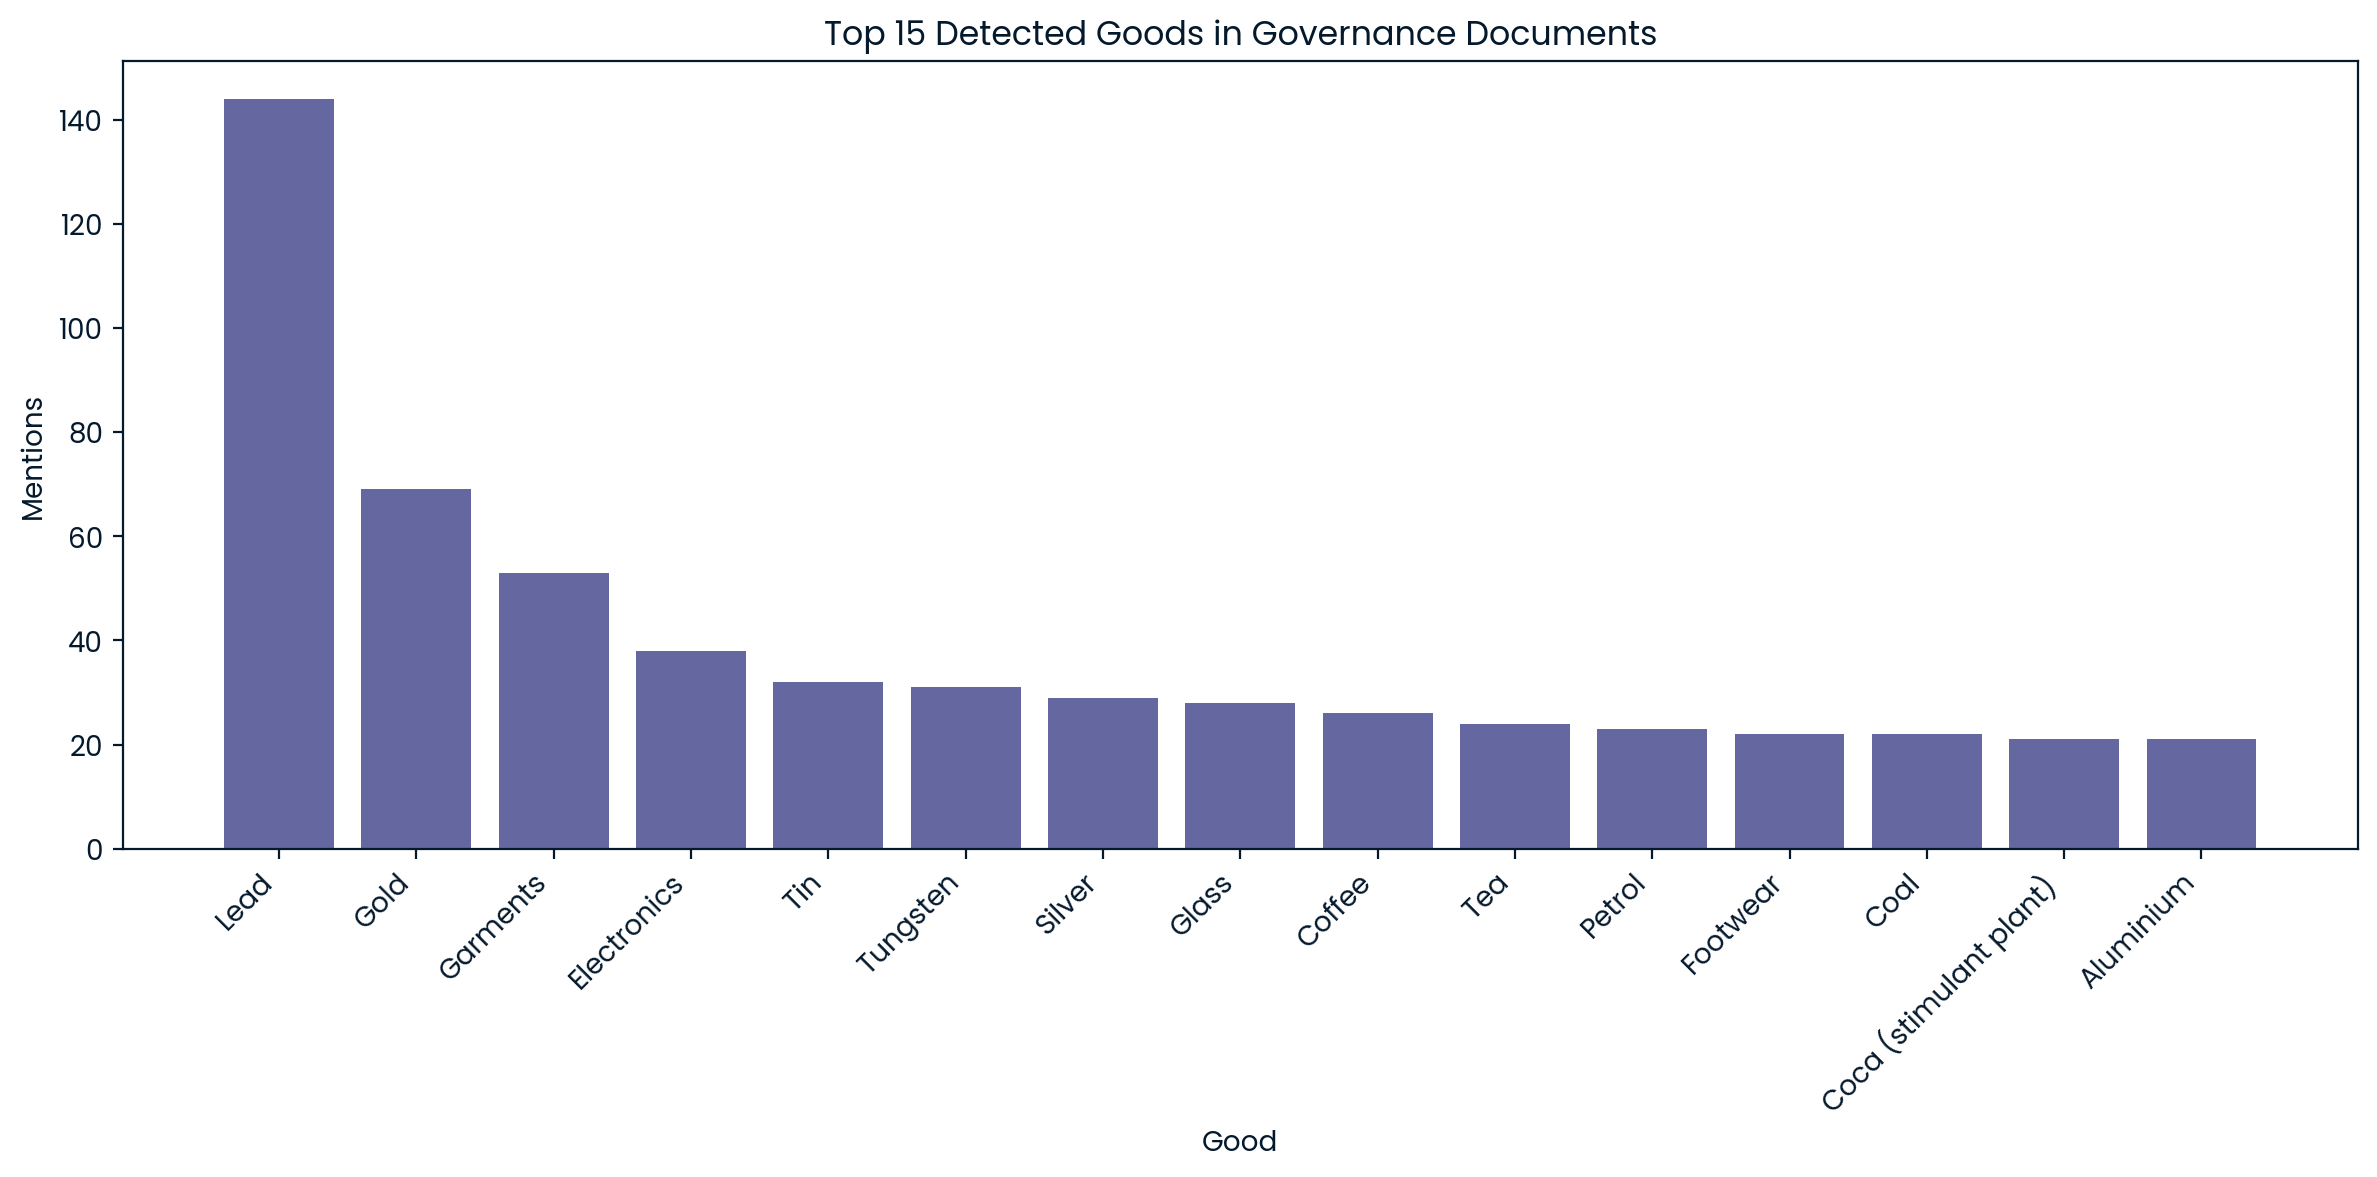

In [15]:
# Save the figure as a PNG file
plt.figure(figsize=(12, 6))
plt.bar(top_goods["Good"], top_goods["Frequency"])
plt.title(f"Top {top_n} Detected Goods in Governance Documents")
plt.xlabel("Good")
plt.ylabel("Mentions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_15_detected_goods.png")
plt.show()

In [16]:
# Show all detected goods deleting duplicates
unique_detected_goods = list(set(all_detected_goods))
unique_detected_goods

['Poultry',
 'Charcoal',
 'Beetroot',
 'Leather',
 'Prawns',
 'Petrol',
 'Gloves',
 'coconut oil',
 'Tin',
 'Shellfish',
 'Sisal',
 'Fish',
 'Baked Goods',
 'Bricks',
 'Ceramics',
 'Crude Palm Oil',
 'Tea',
 'Cement',
 'Hogs',
 'Sand',
 'Chocolate',
 'Bamboo',
 'Garlic',
 'Chickpeas',
 'Toys',
 'Carpets',
 'Footwear',
 'Cassava',
 'Lithium',
 'beans',
 'Rice',
 'Coal',
 'Textiles',
 'Iron',
 'Cotton',
 'Bananas',
 'Furniture',
 'Animal Feed',
 'Diamonds',
 'Sugarcane',
 'Rubber Gloves',
 'Electronics',
 'Flowers',
 'Maize',
 'Zinc',
 'Sapphires',
 'Grapes',
 'Solar Cells',
 'Vanilla',
 'Manganese',
 'Lithium-Ion Batteries',
 'Soap',
 'Aluminium',
 'Yerba Mate',
 'Nickel',
 'Gold',
 'Silver',
 'Coffee',
 'Dried Fish',
 'Soybeans',
 'Sheep',
 'Wheat',
 'Cobalt Ore',
 'Peppers',
 'Caustic Soda',
 'Jewellery',
 'Cucumbers',
 'Raw Sugar',
 'Silk Fabric',
 'Gems',
 'molasses',
 'Beef',
 'Rubber',
 'Glass',
 'Cottonseed (hybrid)',
 'Alcoholic Beverages',
 'Groundnuts',
 'Timber',
 'Tobacco',


## 03.4: Contextual Filtering

Goal: Only count a good (like "Gold") when it's mentioned in a relevant context (e.g., "gold mining", "gold metal", "gold jewellery"), and not in irrelevant contexts e.g. Gold medal/ colour/ hair colour/ "Gold Standard" etc.

## 03.4.1 Manually inputting context keywords

This will be a lot quicker than training a supervised context classifier. However it requires the user to know all of the available context words for each good in the dataset which is unlikely, leading to errors

The next function basically figures out if any of the context keywords appear within 5 words of the good mentioned, if it does, it keeps the mention

In [17]:
# Define context keywords for ambiguous goods
ambiguous_goods_context_keywords = {
    'Gold': ['mining', 'metal', 'jewellery', 'extraction', 'trade', 'resource', 'earrings', 'bracelet', 'bracelets', 'watch', 'necklace', 'necklaces'],
    'Silver': ['mining', 'metal', 'jewellery', 'extraction', 'trade', 'resource', 'earrings', 'bracelet', 'bracelets', 'watch', 'necklace', 'necklaces'],
    'Cotton': ['farming', 'production', 'plantation', 'textile', 'harvest', 'crop'],
    'Rubber': ['plantation', 'farming', 'latex', 'production', 'harvest'],
    'Timber': ['logging', 'wood', 'forest', 'harvest', 'lumber'],
    'Copper': ['mining', 'metal', 'extraction', 'ore'],
    'Tin': ['mining', 'metal', 'extraction', 'ore'],
    'Nickel': ['mining', 'metal', 'extraction', 'ore'],
    'Diamonds': ['mining', 'jewellery', 'gemstone', 'extraction'],
    'Iron': ['mining', 'metal', 'extraction', 'ore', 'steel'],
    'Leather': ['production', 'goods', 'material', 'factory', 'processing'],
    'Textiles': ['production', 'fabric', 'manufacturing', 'weaving', 'materials'],
}

# Function to check for relevant context
def is_relevant_context(text, keyword, context_keywords, window_size=5):
    pattern = r'\b(?:\w+\s+){0,' + str(window_size) + '}' + re.escape(keyword) + r'(?:\s+\w+){0,' + str(window_size) + '}\b'
    matches = re.findall(pattern, text.lower())
    
    for match in matches:
        if any(context_kw in match for context_kw in context_keywords):
            return True  # Relevant context found
    return False  # Not relevant

# Function to filter ambiguous goods based on context
def filter_ambiguous_goods(row):
    filtered_goods = []
    
    for good in row['detected_goods']:
        if good in ambiguous_goods_context_keywords:
            if is_relevant_context(row['extracted_text_clean'], good.lower(), ambiguous_goods_context_keywords[good]):
                filtered_goods.append(good)
        else:
            filtered_goods.append(good)
            
    return filtered_goods

# Apply the context filtering
gov_docs['filtered_goods'] = gov_docs.apply(filter_ambiguous_goods, axis=1)

# Optional: Preview output
gov_docs[['extracted_text_clean', 'detected_goods', 'filtered_goods']].head(20)


,extracted_text_clean,detected_goods,filtered_goods
0,supply chain code of conduct | urban logistics...,[],[]
1,position statement on human rights abbott beli...,[],[]
2,3 2019 accelerating progress toward a sustaina...,"[Coffee, Solar Cells, Cobalt Ore, Tin, Tungste...","[Coffee, Solar Cells, Cobalt Ore, Tungsten, Lead]"
3,gri sustainability reporting standards skip to...,[],[]
4,building foundations for a sustainable future ...,[Cement],[Cement]
5,renewi plc modern slavery statement 2023 intro...,[],[]
6,1 code of conduct code of conduct you are the ...,"[Lead, Garments]","[Lead, Garments]"
7,modern slavery statement amazon (newline) (ne...,"[Cobalt Ore, Tin, Electronics, Tungsten, Cotto...","[Cobalt Ore, Electronics, Tungsten, Lead, Garm..."
8,ethics and compliance skip to main content abo...,[Petrol],[Petrol]
9,supplier code of conduct revised may 2024 1. i...,"[Gold, Tin, Tungsten]",[Tungsten]


As we can see, Tin and Gold seem to be removed wherever they appear leading to erroneous conclusions

The next step is to train a supervised contextual classifier for automated contextual filtering

## 03.4.2 Context Classifcation Model

Will first collect snippet data of ambiguous goods

In [18]:
# Define list of ambiguous goods
ambiguous_goods = [
    'Gold', 'Silver', 'Rubber', 'Timber',
    'Tin', 'Nickel', 'Diamonds', 'Iron', 'Lead'
]

# Function to extract context snippet around each mention of an ambiguous good
def extract_ambiguous_snippets(text, goods_list, window=5):
    words = str(text).split()
    snippets = []
    for i, word in enumerate(words):
        for good in goods_list:
            if word.lower() == good.lower():
                start = max(0, i - window)
                end = min(len(words), i + window + 1)
                snippet = ' '.join(words[start:end])
                snippets.append((good, snippet))
    return snippets

# Extract all context snippets from all rows
snippet_rows = []

for idx, row in gov_docs.iterrows():
    text = row['extracted_text_clean']
    doc_id = row.get('Company_Name', f'Doc_{idx}')
    snippets = extract_ambiguous_snippets(text, ambiguous_goods)
    for good, snippet in snippets:
        snippet_rows.append({
            'Document_ID': doc_id,
            'Ambiguous_Good': good,
            'Text_Snippet': snippet,
            'Label': 'To Label'
        })

# Create DataFrame and save for manual labelling
snippet_df = pd.DataFrame(snippet_rows)
output_path = 'ambiguous_goods_snippets_for_labelling.csv'
snippet_df.to_csv(output_path, index=False)

output_path

'ambiguous_goods_snippets_for_labelling.csv'

In [19]:
snippet_df.shape

(1074, 4)

In [20]:
snippet_df.to_csv('snippets.csv', index=False)

snippet_df has now been exported for manual labelling. This labelled dataset will then be used for training the supervised contextual classifier

Will now import labelled snippet data for model training

In [21]:
labelled_snippets = pd.read_csv('labelled_snippets.csv')

In [22]:
labelled_snippets.head(10)

,Document_ID,Ambiguous_Good,Text_Snippet,Label
0,Doc_2,Lead,"innovators, problem-solvers, and doers will le...",0
1,Doc_2,Lead,"leaders to run fortive businesses, lead large ...",0
2,Doc_2,Lead,inspiring strategic customer obsessed adaptabl...,0
3,Doc_2,Gold,"for tin, tantalum, tungsten, and gold purchase...",1
4,Doc_2,Lead,changing a single process can lead to signific...,0
5,Doc_2,Lead,"company, following the elimination of lead fro...",1
6,Doc_6,Lead,in an investigation that could lead to discipl...,0
7,Doc_6,Lead,"create a conflict of interest, lead to a sense...",0
8,Doc_7,Lead,and related fees that can lead to debt bondage...,0
9,Doc_9,Gold,"the tin, tantalum, tungsten, and gold that it ...",1


### Model Training


The model training will take place in two steps:
1. Text Vectorisation (TF-IDF Vectoriser)
- The text around each good (5-word window) is converted into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency).
- This highlights words that are important in that snippet but rare across the dataset—e.g. "ore", "mine", or "commodity" would get higher weights when disambiguating the word “gold” as a good.
- Each text window becomes a vector representing the relevance of its surrounding terms.
  
2. Logistic Regression Model
- The logistic regression takes these vectors as input and learns to classify them as ‘relevant’ (i.e., referring to a high-risk good) or ‘irrelevant’ (e.g. “gold medal”).
- During training, it learns which words or combinations are strong predictors of contextual relevance.
- Once trained, it can filter new mentions of goods and retain only those in meaningful, risk-related contexts.

In [23]:
# Separate features and labels
X = labelled_snippets["Text_Snippet"]
y = labelled_snippets["Label"]

# Convert text to numeric vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[164   0]
 [ 43   8]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       164
           1       1.00      0.16      0.27        51

    accuracy                           0.80       215
   macro avg       0.90      0.58      0.58       215
weighted avg       0.84      0.80      0.74       215



The model pefroms very badly. We suspect this is because of the relatively few contextually relevant use cases of "lead". We will do some analysis of this + then potentially drop 'lead' from the analysis to improve model performance

In [24]:
# Filter the dataframe for ambiguous goods with Lead that are also Label 1
ambiguous_goods_with_lead_label_1 = labelled_snippets[
    (labelled_snippets["Ambiguous_Good"].str.contains("Lead", na=False)) & 
    (labelled_snippets["Label"] == 1)
]

# Count the number of such entries
count_ambiguous_goods_with_lead_label_1 = ambiguous_goods_with_lead_label_1.shape[0]
count_ambiguous_goods_with_lead_label_1

12

Number of correct instances of Lead are very few, therefore will drop Lead from our analysis as it will cloud our analysis

Will now run the model only on the data excluding lead

In [25]:
# Filter out rows where Ambiguous_Good contains "Lead"
labelled_snippets_filtered = labelled_snippets[~labelled_snippets["Ambiguous_Good"].str.contains("Lead", na=False)]

# Display the first few rows of the filtered dataframe
labelled_snippets_filtered.head()

,Document_ID,Ambiguous_Good,Text_Snippet,Label
3,Doc_2,Gold,"for tin, tantalum, tungsten, and gold purchase...",1
9,Doc_9,Gold,"the tin, tantalum, tungsten, and gold that it ...",1
19,Doc_15,Gold,"companies assessed, earning us a gold medal. t...",0
82,Doc_29,Gold,"gfms, ice benchmark administration, world gold...",0
83,Doc_29,Gold,for luxury jewellery (source: world gold counc...,0


In [26]:
labelled_snippets_filtered.shape

(402, 4)

In [27]:
# Separate features and labels
X = labelled_snippets_filtered["Text_Snippet"]
y = labelled_snippets_filtered["Label"]

# Convert text to numeric vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[34  3]
 [ 2 42]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        37
           1       0.93      0.95      0.94        44

    accuracy                           0.94        81
   macro avg       0.94      0.94      0.94        81
weighted avg       0.94      0.94      0.94        81



The context classifier works quite well on unseen test data. Will now save the model

In [28]:
import joblib

# Save the trained model
joblib.dump(clf, 'logistic_regression_model.pkl')

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.
